# Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load data using a Keras utility & create dataset

In [2]:
batch_size = 32
img_height = 180
img_width = 180


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory('CNNDaten/Train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1051 files belonging to 3 classes.
Using 841 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "CNNDaten/Valid",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 93 files belonging to 3 classes.


In [5]:
class_names = train_ds.class_names
print(class_names)


['Dosenoeffner', 'Flaschenoeffner', 'Korkenzieher']


# Visualize the data

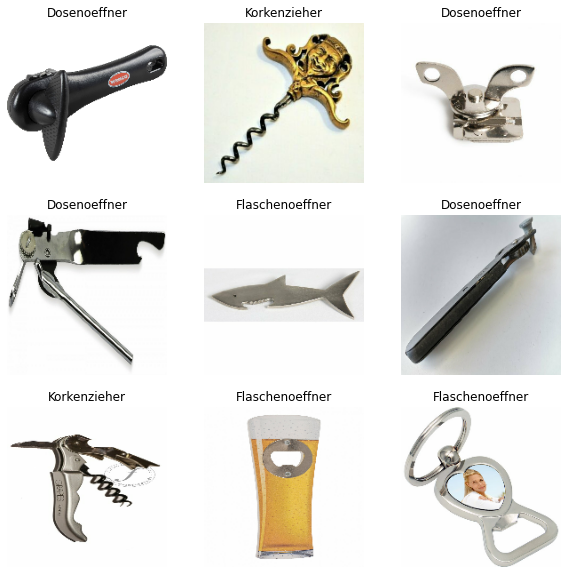

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


# Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Standardize the data

In [9]:
normalization_layer = layers.Rescaling(1./255)



In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.00013314375 1.0


# Create the model

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


# Compile the model

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(monitor="val_loss", patience=3)

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128,
  callbacks=[early]
)

Epoch 1/20
27/27 [==============================] - 7s 260ms/step - loss: 1.4199 - accuracy: 0.3864 - val_loss: 1.0555 - val_accuracy: 0.3978
Epoch 2/20
27/27 [==============================] - 6s 216ms/step - loss: 1.0124 - accuracy: 0.4946 - val_loss: 0.9729 - val_accuracy: 0.5376
Epoch 3/20
27/27 [==============================] - 6s 223ms/step - loss: 0.8090 - accuracy: 0.6326 - val_loss: 0.9173 - val_accuracy: 0.4731
Epoch 4/20
27/27 [==============================] - 6s 224ms/step - loss: 0.5804 - accuracy: 0.7693 - val_loss: 1.0220 - val_accuracy: 0.5806
Epoch 5/20
27/27 [==============================] - 5s 200ms/step - loss: 0.3866 - accuracy: 0.8633 - val_loss: 0.9073 - val_accuracy: 0.6882
Epoch 6/20
27/27 [==============================] - 6s 209ms/step - loss: 0.2170 - accuracy: 0.9215 - val_loss: 1.0200 - val_accuracy: 0.6882
Epoch 7/20
27/27 [==============================] - 6s 208ms/step - loss: 0.1507 - accuracy: 0.9548 - val_loss: 1.5857 - val_accuracy: 0.6774
Epoch 

# Model summary

In [15]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train the model

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
27/27 [==============================] - 6s 224ms/step - loss: 0.1351 - accuracy: 0.9620 - val_loss: 1.4946 - val_accuracy: 0.7097
Epoch 2/10
27/27 [==============================] - 5s 202ms/step - loss: 0.0953 - accuracy: 0.9643 - val_loss: 1.5725 - val_accuracy: 0.6989
Epoch 3/10
27/27 [==============================] - 6s 207ms/step - loss: 0.0510 - accuracy: 0.9834 - val_loss: 1.8693 - val_accuracy: 0.7204
Epoch 4/10
27/27 [==============================] - 5s 202ms/step - loss: 0.0409 - accuracy: 0.9893 - val_loss: 1.8358 - val_accuracy: 0.7097
Epoch 5/10
27/27 [==============================] - 6s 221ms/step - loss: 0.0296 - accuracy: 0.9941 - val_loss: 2.1729 - val_accuracy: 0.7097
Epoch 6/10
27/27 [==============================] - 7s 266ms/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 2.2663 - val_accuracy: 0.7204
Epoch 7/10
27/27 [==============================] - 7s 262ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 2.5266 - val_accuracy: 0.7312
Epoch 

# Visualize training results

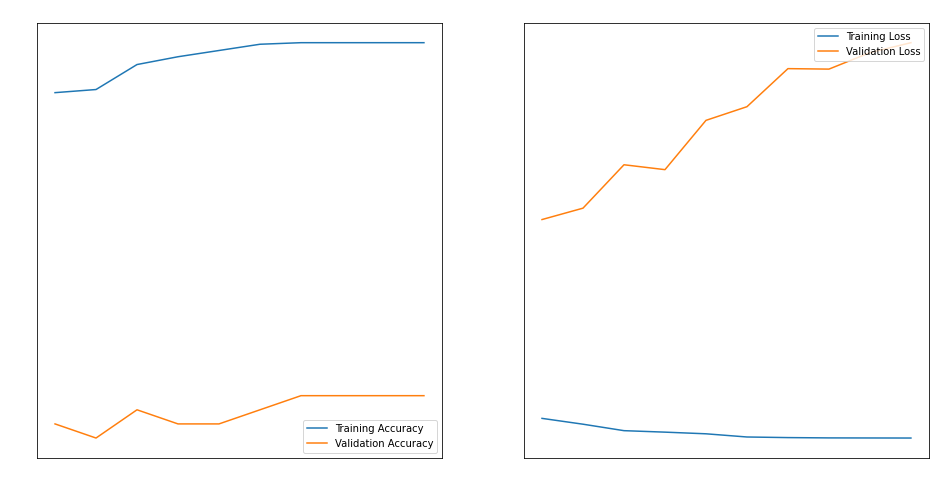

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy',color='white')

plt.subplot(1, 2, 2)
plt.tick_params(axis='x',colors='white')
plt.tick_params(axis='y',colors='white')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss',color='white')
plt.show()


# Class Prediction with our trained model

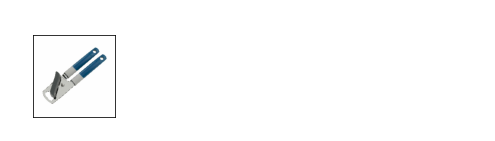

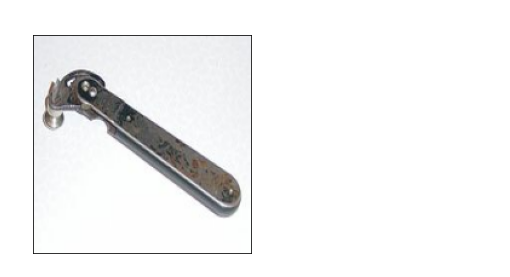

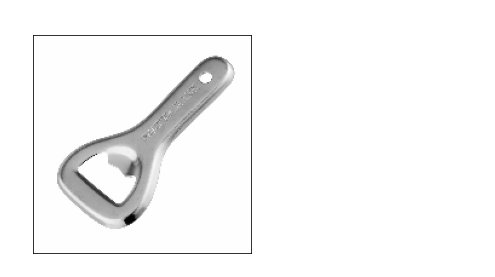

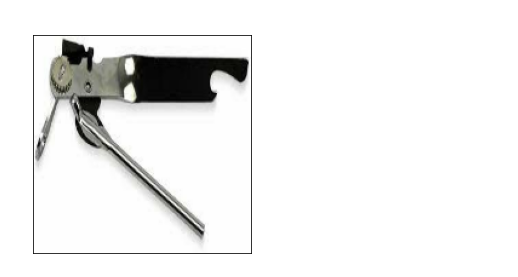

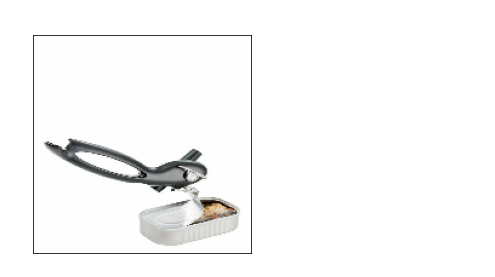

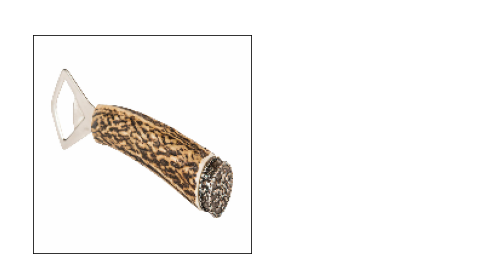

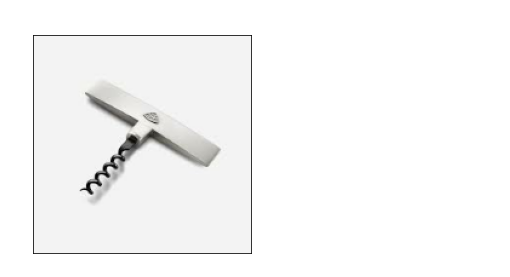

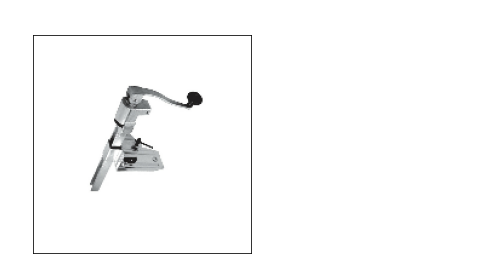

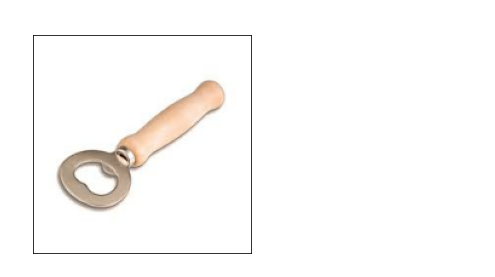

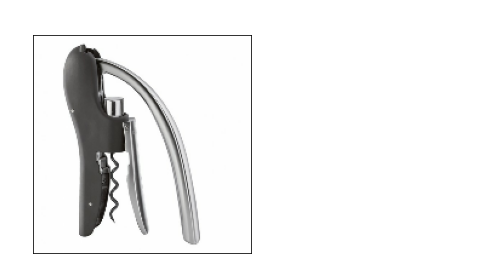

In [18]:
# Vorhersage in das Array predictions[] speichern
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)
# Batch für Testbilder
batch_number = 14
# Anzeigen des zufällig ausgewählten Bildes
plt.figure(figsize=(5, 2))
plt.axis("off") # Keine Achsen im Plot anzeigen
ax = plt.subplot(1, 3, 1)  # Erstellung eines Subplots/Platzhalter für das Bild

# Testbilder Anzeigen mit Vorhersage: Immer ein Batch
for i in range(0,10):
  for images, labels in val_ds.take(batch_number):     # .take(?) --> ?: Batch Nummer (Alle Bilder werden in Batches unterteilt abhängig von der Variable batch_size
    plt.imshow(images[i].numpy().astype("uint8"))  # Einfügen/Plotten des Bildes
    title = " Prob(Dosenoeffner): " + str(round(predictions[((batch_number)*4)+i,0],2)) + " Prob(Flaschenoeffner): " + str(round(predictions[((batch_number)*4)+i,1],2))+ " Prob(Korkenzieher): " + str(round(predictions[((batch_number)*4)+i,2],2)) # Titel des Bildes für Ausgabe der Wahrscheinlichkeiten
    plt.title(title, loc="left",color='white')
    plt.tick_params(axis='x',colors='white')
    plt.tick_params(axis='y',colors='white')
    plt.suptitle("Es sollte sein: " + str(class_names[labels[i]]),color = 'white')  # Subtitel für Ausgabe der Vorraussage
  plt.show()  # Fenster anzeigen